In [15]:
# This branch of qiskit is required:  pip install git+https://github.com/LNoorl/qiskit-terra.git@feature/sk-pass

import numpy as np
import dreamcoder as dc
from dreamcoder.domains.quantum_circuits.primitives import *
from dreamcoder.domains.quantum_circuits.tasks import *
import dill as pickle 
import time
from tqdm import trange, tqdm
import random
import bin.binutil
import datetime
import glob
import os
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Begin analysis

Choose target experiment output

In [16]:
# folder = "experimentOutputs/quantum/2022-07-21T09:35:32.628360" # 3 qubits
# folder = "experimentOutputs/quantum/2023-03-22T01:42:59.384211" # 3 qubits 2023
# folder = "experimentOutputs/quantum/2023-03-24T10:26:53.508370" # 3 qubits 2023 new run <-- analyze this
folder = "experimentOutputs/quantum/2023-03-27T15:35:24.118009" # 3 qubits 2023 new run, trying to fix fidelity
folder = "experimentOutputs/quantum/2023-03-28T18:51:39.707375" # consistency check
folder = "experimentOutputs/quantum/2023-03-28T19:15:45.886847" # 3 qubits 2023 new run, trying to fix fidelity again


# folder = "experimentOutputs/quantum/2022-07-21T09:39:38.092394" # 3 limited
# folder = "experimentOutputs/quantum/2023-03-24T17:33:42.558062" # 3 limited 2023 <-- analyze this
# folder = "experimentOutputs/quantum/2023-03-27T15:36:07.621881" # 3 limited 2023 <-- analyze this
folder = "experimentOutputs/quantum/2023-03-28T19:15:45.929940" # 3 qubits 2023 new run, trying to fix fidelity again


name = {}
simplification = {}
depth = {}


In [17]:
# The following are auxiliary functions to handle invented primitives


def get_primitive_arguments(tp, arguments,last_qubit=0):
    # Get argument to run a primitive
    if len(tp.arguments)!=0:
        if tp.arguments[0].name=="int":
            arguments.append(last_qubit)
            last_qubit+=1
        elif tp.arguments[0].name=="tcircuit":
            arguments.append(["no_op"])
        return get_primitive_arguments(tp.arguments[1], arguments, last_qubit)
    
    else:
        for i in range(len(arguments)):
            if type(arguments[i]) == list:
                arguments[i] = no_op(last_qubit)
        return arguments
    
def randomize_arguments(arguments):
    idx_to_randomize = []
    for idx, element in enumerate(arguments):
        if isinstance(element, (int,np.int32,np.int64)):
            idx_to_randomize.append(idx)
    numbers = np.random.choice(np.arange(len(idx_to_randomize)),size=len(idx_to_randomize))
    for idx, n in zip(idx_to_randomize, numbers):
        arguments[idx] = n
    return arguments


def lb(s,T=20):
    s = s.split()
    l = []
    n = 0
    for w in s:
        if n + len(w) > T:
            l.append("<br />")
            n = 0
        n += len(w)
        l.append(w)
    return " ".join(l)

def get_program_children(program):
    try:
        return {k: getName(k) for _,k in program.body.walk() if k.isInvented}
    except:
        return {k: getName(k) for _,k in program.walk() if k.isInvented}

def get_program_simplification(program):
    if program in name: return name[program]
    children = get_program_children(program)
    simplification_ = program
    for k,childName in children.items():
        simplification_ = simplification_.substitute(k, dc.program.Primitive(childName,ty=None,value=None))
    return simplification_    
    
def getName(program):
    if program in name: return name[program]
    children = get_program_children(program)
    simplification_ = get_program_simplification(program.body)
    # for original, simplified in nameSimplification.items():
    #     simplification_ = simplification_.substitute(Primitive(original,None,None),
    #                                                     Primitive(simplified,None,None))
    name[program] = "f%d"%len(name)
    # name[program] = f"f{len(name):03d}" # need to make name unambigous (f1 and f13 is not nice for easy string replacement)
    
    simplification[program] = simplification_
    depth[program] = 1 + max([depth[k] for k in children] + [0])
    return name[program]

def get_primitive_lambda(n_qubit, operation_name):
    if n_qubit==1:
        return lambda old_circuit, q: n_qubit_gate(old_circuit, q, operation_name=operation_name)
    elif n_qubit==2:
        return lambda old_circuit, q1, q2: n_qubit_gate(old_circuit, q1, q2, operation_name=operation_name)
    elif n_qubit==3:
        return lambda old_circuit, q1, q2,q3: n_qubit_gate(old_circuit, q1, q2, q3, operation_name=operation_name) 
    elif n_qubit==4:
        return lambda old_circuit, q1, q2,q3,q4: n_qubit_gate(old_circuit, q1, q2, q3,q4, operation_name=operation_name) 
    elif n_qubit==5:
        return lambda old_circuit, q1, q2,q3,q4,q5: n_qubit_gate(old_circuit, q1, q2, q3,q4,q5, operation_name=operation_name)       
    elif n_qubit==6:
        return lambda old_circuit, q1, q2,q3,q4,q5, q6: n_qubit_gate(old_circuit, q1, q2, q3,q4,q5,q6, operation_name=operation_name)  
    elif n_qubit==7:
        raise Exception("ask Kevin.")     
    
def get_qk_lambda(n_qubit, gate):
    if n_qubit==1:
        return lambda QT,q1: QT.circuit.append(gate, (QT.q(q1),))
    elif n_qubit==2:
        return lambda QT, q1,q2: QT.circuit.append(gate, (QT.q(q1), QT.q(q2)))
    elif n_qubit==3:
        return lambda QT, q1,q2,q3: QT.circuit.append(gate, (QT.q(q1), QT.q(q2), QT.q(q3)))
    elif n_qubit==4:
        return lambda QT, q1,q2,q3,q4: QT.circuit.append(gate, (QT.q(q1), QT.q(q2), QT.q(q3), QT.q(q4)))
    elif n_qubit==5:
        return lambda QT, q1,q2,q3,q4,q5: QT.circuit.append(gate, (QT.q(q1), QT.q(q2), QT.q(q3), QT.q(q4),QT.q(q5)))
    elif n_qubit==6:
        return lambda QT, q1,q2,q3,q4,q5,q6: QT.circuit.append(gate, (QT.q(q1), QT.q(q2), QT.q(q3), QT.q(q4),QT.q(q5),QT.q(q6)))
    elif n_qubit==7:
        raise Exception("ask Kevin.") 
    
def f_circuit(circuit_unitary, *qubit, circuit_template):
    # eprint(circuit_template)
    n_args, circuit_ops = circuit_template
    circuit_ops = list(circuit_ops)
    # apply template
    # returns a tuple of circuit ops ( ("gate", 1, 2, ...), ...   )
    circuit_ops =  ( ((op[0],*[qubit[q] for q in op[1:]])) for op in circuit_ops)
    
    for op in circuit_ops:
        circuit_unitary = full_op_names[op[0]](circuit_unitary, *op[1:])
    return circuit_unitary    

def print_simplified_grammar(grammar):
    def productionKey(primitive):
        (l, t, p) = primitive  #likelihood, type, program_object
        return l is not None and -l

    if grammar.continuationType is not None:
        lines = ["continuation : %s" % grammar.continuationType]
    else:
        lines = []
        
    lines += ["%f\tt0\t$_" % grammar.logVariable]
    for l, t, p in sorted(grammar.productions, key=productionKey):
        if isinstance(p,dc.program.Invented):
            p_string = str(get_program_simplification(dc.program.Program.parse(str(p)))[1:])
            p_name = f"f{p_string}:{list(simplification.values())[int(p_string)]}"
        else:
            p_name = str(p)
        if l is not None:
            l = f"{l}\t{p_name: <75}\t{t}" 
        else:
            l = "-Inf\t{p_name: <75}\t{t}"
        if not t.isArrow() and isinstance(p, dc.program.Invented):
            try:
                l += "\teval = {p.evaluate([])}" 
            except BaseException:
                pass

        lines.append(l)
    return "\n".join(lines)

Load data files

In [4]:
files = glob.glob(f"{folder}/quantum_train_dumped_results_*")
files.sort(key=lambda x: int(x.split("_")[-2]))
max_iteration = int(files[-1].split("_")[-2])
# max_iteration = 94

with open(f"{folder}/arguments.pickle","rb") as f:
    arguments = pickle.load(f)
    
dc.domains.quantum_circuits.primitives.GLOBAL_NQUBIT_TASK = n_qubit_tasks = int(arguments["nqubit"])
dc.domains.quantum_circuits.primitives.GLOBAL_LIMITED_CONNECTIVITY = arguments["limitedConnectivity"]

    
with open(f"{folder}/quantum_train_dumped_results_{max_iteration}_","rb") as f:
    results = pickle.load(f)

with open(f"{folder}/quantum_test_{max_iteration}_dumped_results_0_","rb") as f:
    results_test = pickle.load(f)

In [5]:
with open(f"{folder}/quantum_test-train_{max_iteration}_dumped_results_0_","rb") as f:
    results_validation = pickle.load(f)
    
with open(f"{folder}/solved_train.txt", "r") as f:
    f_frontiers_validation = f.readlines()
validation_frontiers = [int(t) for t in f_frontiers_validation]


In [28]:
# This would just be a consistency check: can we enumerate the same grammar we generated?
with open(f"{folder}/quantum_full_dumped_results_0_","rb") as f:
   results_full = pickle.load(f)
   
print(f"It was able to reconstruct {results_full.learningCurve[-1]}/{len(results_full.frontiersOverTime)} tasks")
if (results_full.learningCurve[-1]!= len(results_full.frontiersOverTime)):
    for idx,(task, frontier) in enumerate(results_full.frontiersOverTime.items()):
        if len(frontier[-1].entries)==0:
            print("TASK UNSOLVED!")
            true_circuit = get_qiskit_circuit((n_qubit_tasks, task.target_circuit))
            print(f"---------------------------------------")
            print(f"Task {task.name}")
            print("True")
            print(true_circuit.circuit)
            break
    
    raise(Exception(
        "Since it was not able to enumerate all full tasks with the full set of gates, there must be a bug in the code checking if a circuits gives the requested unitary. This is not good."))
    
for idx,(task, frontier) in enumerate(results_full.frontiersOverTime.items()):
    if abs(task.target_circuit_evaluation.max())> 3:
        print("This is not good, really. Not good.")
        print("There must be a bug in the comparison of unitary matrices up to a phase")
    

It was able to reconstruct 49688/49688 tasks


Check performance: how many tasks have been solved?

In [8]:
max(results_validation.trainSearchTime.values())

133.48325204849243

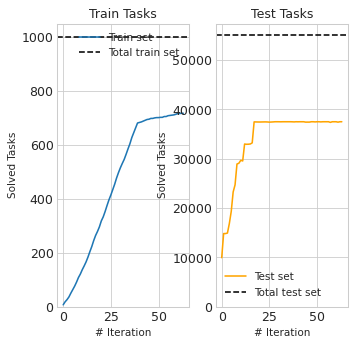

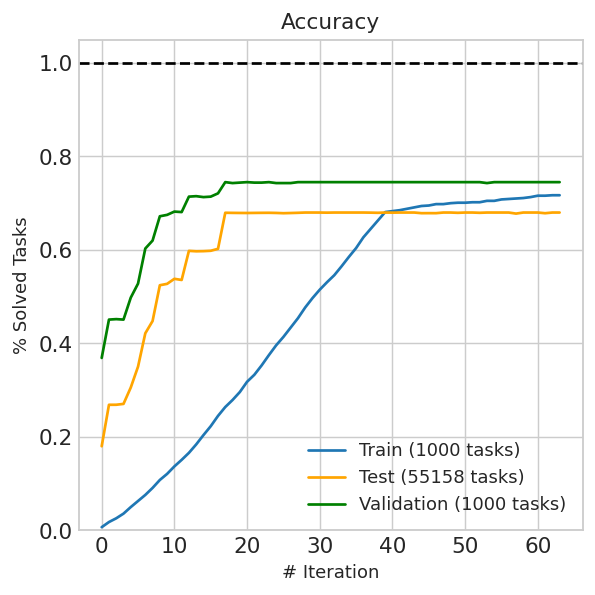

Train set:	717/1000 (71.70%)
Test set:	37507/55158 (68.00%)


In [7]:
## Test results do not have a learning curve (since we always start from scratch).
## This is the slow way to load the test results.
## Since it is slow, we also save the values during the experiments.
# test_frontiers = []
# for i in trange(max_iteration):
#     with open(f"{folder}/quantum_test_{i+1}_dumped_results_0_","rb") as f:
#         r_test = pickle.load(f)
#     test_frontiers.append(r_test.learningCurve[0])

with open(f"{folder}/solved_test.txt", "r") as f:
    f_frontiers = f.readlines()

test_frontiers = [int(t) for t in f_frontiers]

%matplotlib inline
plt.figure(figsize=[5,5], dpi=75)
plt.subplot(1,2,1)
plt.plot(np.arange(len(results.learningCurve)),results.learningCurve, label="Train set")
plt.axhline(len(results.frontiersOverTime),linestyle="--",c="black", label="Total train set")
plt.title("Train Tasks")
plt.xlabel("# Iteration")
plt.ylabel("Solved Tasks")
plt.ylim([0,None])
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.arange(len(test_frontiers)),test_frontiers,c="orange", label="Test set")
plt.axhline(len(results_test.frontiersOverTime),linestyle="--",c="black", label="Total test set")
# plt.axhline(results_test.learningCurve[-1],linestyle="--",c="orange", label="Total test set")
plt.legend()
plt.title("Test Tasks")
plt.xlabel("# Iteration")
plt.ylabel("Solved Tasks")
plt.ylim([0,None])
plt.show()

# Same plots, but overlapped
%matplotlib inline
plt.figure(figsize=[5,5], dpi=130)
plt.plot(np.arange(len(results.learningCurve)),np.array(results.learningCurve)/len(results.frontiersOverTime), label=f"Train ({len(results.frontiersOverTime)} tasks)")
plt.plot(np.arange(len(test_frontiers)),np.array(test_frontiers)/len(results_test.frontiersOverTime),c="orange", label=f"Test ({len(results_test.frontiersOverTime)} tasks)")
plt.plot(np.arange(len(validation_frontiers)),np.array(validation_frontiers)/len(results_validation.frontiersOverTime),c="green", label=f"Validation ({len(results_validation.frontiersOverTime)} tasks)")
plt.axhline(1,linestyle="--",c="black")
plt.xlabel("# Iteration")
plt.ylabel("% Solved Tasks")
plt.ylim([0,None])
plt.legend()
plt.title("Accuracy")
plt.savefig("experimentOutputs/fig3a.pdf")
plt.show()

print(f"Train set:\t{np.array(results.learningCurve)[-1]}/{len(results.frontiersOverTime)} ({(np.array(results.learningCurve)[-1]/len(results.frontiersOverTime))*100:2.2f}%)")
print(f"Test set:\t{np.array(test_frontiers)[-1]}/{len(results_test.frontiersOverTime)} ({(np.array(test_frontiers)[-1]/len(results_test.frontiersOverTime))*100:2.2f}%)")


Get extracted primitives.
Add extracted primitives to GLOBAL primitives

In [11]:
invented_primitives = {p for p in results.grammars[-1].primitives if p.isInvented }
for p in invented_primitives:
    getName(p)

depths = {depth[p] for p in invented_primitives}
depth2primitives = {d: {p for p in invented_primitives if depth[p] == d }
                    for d in depths}
folder_primitives = f"{folder}/primitives"

if not os.path.exists(folder_primitives):
    os.mkdir(folder_primitives)
# Define primitive circuit operations as globals
for i, (original,simplified) in enumerate(simplification.items()):
    arguments = get_primitive_arguments(original.tp,[])
    n_qubit=len(arguments) -1
    
    dc.program.Primitive.GLOBALS[name[original]] = dc.program.Primitive(
        name=name[original], 
        ty=original.tp,
        value=dc.utilities.Curried(get_primitive_lambda(n_qubit, name[original])))
    
    program = dc.program.Program.parse(str(original))
    
    while 1:
        try:
            circuit = execute_program(program, arguments)
            break
        except QuantumCircuitException:
            arguments =  randomize_arguments(arguments)
            print("Invalid circuit -> Randomizing arguments: ", arguments)
        
    dc.domains.quantum_circuits.primitives.full_op_names[name[original]]= \
        lambda tensor, *qubit, circuit_template=circuit: f_circuit(tensor, *qubit, circuit_template=circuit_template)
    
    simplified_program = dc.program.Program.parse(str(simplified))
    simplified_circuit = execute_program(simplified_program, arguments)
    qk_circuit = get_qiskit_circuit(simplified_circuit).circuit
    qk_circuit.name = name[original]
    dc.domains.quantum_circuits.primitives.qiskit_full_op_names[name[original]]= \
        get_qk_lambda(n_qubit, qk_circuit.to_gate())
    
    eta_long = dc.program.EtaLongVisitor().execute(simplified_program)
    print(f"{name[original]}: {eta_long}") #EtaLong for a better program string
    # print(original)
    print("Simplified circuit")
    print(qk_circuit)
    qk_circuit.draw(output="mpl", filename=f"{folder_primitives}/{i}.png")
    print("Expanded circuit")
    print(get_qiskit_circuit(circuit).circuit)
    get_qiskit_circuit(circuit).circuit.draw(output="mpl", filename=f"{folder_primitives}/r{i}.png")
    print("-------------------------------------------")

f0: (lambda (lambda (t (t $0 $1) $1)))
Simplified circuit
   ┌───┐┌───┐
q: ┤ T ├┤ T ├
   └───┘└───┘
Expanded circuit
   ┌───┐┌───┐
q: ┤ T ├┤ T ├
   └───┘└───┘
-------------------------------------------
f1: (lambda (lambda (lambda (f0 $0 (cnot $1 $2 $0)))))
Simplified circuit
     ┌───┐┌────┐
q_0: ┤ X ├┤ f0 ├
     └─┬─┘└────┘
q_1: ──■────────
                
Expanded circuit
     ┌───┐┌───┐┌───┐
q_0: ┤ X ├┤ T ├┤ T ├
     └─┬─┘└───┘└───┘
q_1: ──■────────────
                    
-------------------------------------------
f2: (lambda (lambda (lambda (h (cnot (h $0 $1) $2 $1) $1))))
Simplified circuit
     ┌───┐┌───┐┌───┐
q_0: ┤ H ├┤ X ├┤ H ├
     └───┘└─┬─┘└───┘
q_1: ───────■───────
                    
Expanded circuit
     ┌───┐┌───┐┌───┐
q_0: ┤ H ├┤ X ├┤ H ├
     └───┘└─┬─┘└───┘
q_1: ───────■───────
                    
-------------------------------------------
f3: (lambda (lambda (lambda (lambda (f1 $0 (cnot (f2 $1 $2 $3) $1 $2) $1)))))
Simplified circuit
                 ┌─────┐

Plot extracted primitives during time 

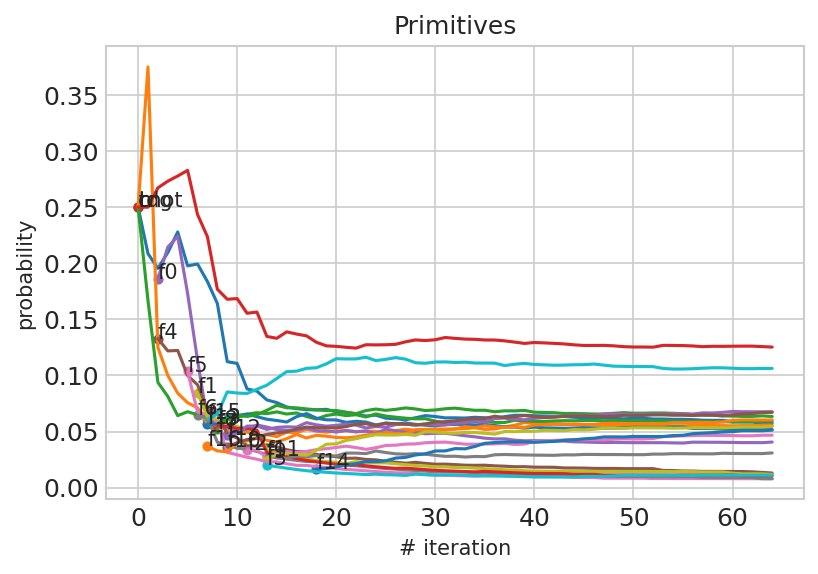

In [12]:
primitive_likelihood = {}

for idx_grammar, grammar in enumerate(results.grammars):
    for production in grammar.productions:
        p = production[-1]
        if isinstance(p,dc.program.Invented):
            p_string = str(get_program_simplification(dc.program.Program.parse(str(p)))[1:])
            p_name = f"f{p_string}"
        else: p_name = p
        
        if p_name not in primitive_likelihood:
            primitive_likelihood[p_name]=[]
        primitive_likelihood[p_name].append([idx_grammar,np.exp(production[0])])


# Normalize the production probability
normalization_weights = {i:0. for i in range(max_iteration+2)}
for primitive in primitive_likelihood.values():
    for idx, likelihood in primitive:
        normalization_weights[idx] += likelihood
        
for primitive in primitive_likelihood.values():
    for i in range(len(primitive)):
        primitive[i][1]/=normalization_weights[primitive[i][0]]


plt.figure(dpi=150)
plt.title("Primitives")
for primitive, likelihoods in primitive_likelihood.items():
    l_array = np.array(likelihoods)
    plt.plot(l_array[:,0], l_array[:,1], label=primitive)
    plt.scatter(*l_array[0], s=15)
    plt.annotate(primitive, l_array[0])
plt.xlabel("# iteration")
plt.ylabel("probability")
plt.show()

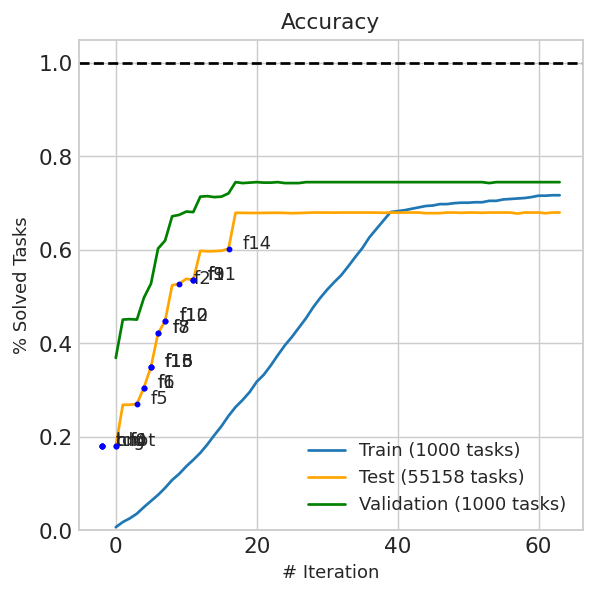

In [13]:
# Same plots, but overlapped
%matplotlib inline
plt.figure(figsize=[5,5], dpi=130)
plt.plot(np.arange(len(results.learningCurve)),np.array(results.learningCurve)/len(results.frontiersOverTime), label=f"Train ({len(results.frontiersOverTime)} tasks)")
plt.plot(np.arange(len(test_frontiers)),np.array(test_frontiers)/len(results_test.frontiersOverTime),c="orange", label=f"Test ({len(results_test.frontiersOverTime)} tasks)")
plt.plot(np.arange(len(validation_frontiers)),np.array(validation_frontiers)/len(results_validation.frontiersOverTime),c="green", label=f"Validation ({len(results_validation.frontiersOverTime)} tasks)")
plt.axhline(1,linestyle="--",c="black")
plt.xlabel("# Iteration")
plt.ylabel("% Solved Tasks")
plt.ylim([0,None])
plt.legend()
plt.title("Accuracy")

for primitive, likelihoods in primitive_likelihood.items():
    l_array = np.array(likelihoods)
    y_location = (np.array(test_frontiers)/len(results_test.frontiersOverTime))[int(np.clip(l_array[0][0]-2,0,None))]
    plt.scatter(l_array[0][0]-2,y_location, s=5, color="blue", zorder=10)
    plt.annotate(primitive, (l_array[0][0],y_location))

plt.show()

Count solved/unsolved

In [ ]:
n_solved = 0
r=results_test
for idx,(task, frontier) in tqdm(enumerate(r.frontiersOverTime.items())):
    f = frontier[-1]
    if len(f.entries)>0:
       n_solved+=1
        
print(f"Solved {n_solved}/{len(r.taskSolutions)} tasks. ({n_solved/len(r.taskSolutions)*100:2.2f}%)")

50187it [00:00, 414916.40it/s]

Solved 48461/50187 tasks. (96.56%)


Analyze solved and unsolved tasks

In [14]:
solved_tasks = []
primitive_counts = {}
r = results
for idx,(task, frontier) in enumerate(r.frontiersOverTime.items()):
    if idx<4000:
        f = frontier[-1]
        true_circuit = get_qiskit_circuit((n_qubit_tasks, task.target_circuit))
        print(f"---------------------------------------")
        print(f"Task {task.name}")
        print("True")
        print(true_circuit.circuit)
        
        if len(f.entries)>0:
            solved = f.entries[0]
            program = solved.program
            simplified_program = get_program_simplification(program)
            #reparse to update primitive functions
            simplified_program = dc.program.Program.parse(str(simplified_program))
            # arguments = task.examples[0][0] weird bug! ask Kevin
            arguments = (*range(n_qubit_tasks),(n_qubit_tasks,()))
            circuit = execute_program(simplified_program,arguments)
            
            # print(f"originally proposed circuit: {program}")
            print(f"reconstructed_circuit: {simplified_program}")
            reconstructed_circuit = get_qiskit_circuit(circuit)
            print(reconstructed_circuit.circuit)

            depth = len(execute_program(program,arguments)[1])
            solved_tasks.append([task,circuit, depth])
            
            for gate, *qubit in circuit[1]:
                if gate not in primitive_counts: primitive_counts[gate]=0
                primitive_counts[gate]+=1
        else:
            print("TASK UNSOLVED!")
            # break
print(f"Solved {len(solved_tasks)}/{len(r.taskSolutions)} tasks. ({len(solved_tasks)/len(r.taskSolutions)*100:2.2f}%)")

---------------------------------------
Task t_000_(lambda (lambda (lambda (lambda $0))))
True
     
q_0: 
     
q_1: 
     
q_2: 
     
reconstructed_circuit: (lambda (lambda (lambda (lambda $0))))
     
q_0: 
     
q_1: 
     
q_2: 
     
---------------------------------------
Task t_001_(lambda (lambda (lambda (lambda (h $0 $1)))))
True
     ┌───┐
q_0: ┤ H ├
     └───┘
q_1: ─────
          
q_2: ─────
          
reconstructed_circuit: (lambda (lambda (lambda (lambda (h $0 $1)))))
     ┌───┐
q_0: ┤ H ├
     └───┘
q_1: ─────
          
q_2: ─────
          
---------------------------------------
Task t_002_(lambda (lambda (lambda (lambda (h $0 $2)))))
True
          
q_0: ─────
     ┌───┐
q_1: ┤ H ├
     └───┘
q_2: ─────
          
reconstructed_circuit: (lambda (lambda (lambda (lambda (h $0 $2)))))
          
q_0: ─────
     ┌───┐
q_1: ┤ H ├
     └───┘
q_2: ─────
          
---------------------------------------
Task t_003_(lambda (lambda (lambda (lambda (h $0 $3)))))
True
       

Task likelihood

Estimating likelihood of solving tasks at the beginning

In [ ]:
def get_S(q_1):
    return (("t", q_1), ("t", q_1))


def get_SX(q_1):
    return (("hadamard", q_1), ("t", q_1), ("t", q_1), ("hadamard", q_1))


def get_SXDG(q_1):
    return (("hadamard", q_1), ("tdg", q_1), ("tdg", q_1), ("hadamard", q_1))


def get_X(q_1):
    return (("hadamard", q_1), ("t", q_1), ("t", q_1), ("t", q_1), ("t", q_1), ("hadamard", q_1))


def get_Y(q_1):
    return (("hadamard", q_1), ("t", q_1), ("t", q_1), ("hadamard", q_1), ("tdg", q_1), ("tdg", q_1), ("hadamard", q_1), ("t", q_1), ("t", q_1))


def get_Z(q_1):
    return (("t", q_1), ("t", q_1), ("t", q_1), ("t", q_1))


def get_CY(q_2, q_1):
    return (("tdg", q_1), ("tdg", q_1), ("cnot", q_2, q_1), ("t", q_1), ("t", q_1))


def get_CZ(q_1, q_2):
    return (("hadamard", q_1), ("cnot", q_2, q_1), ("hadamard", q_1))


def get_CH(q_2, q_1):
    return (("t", q_1), ("t", q_1), ("hadamard", q_1), ("t", q_1), ("cnot", q_2, q_1), ("tdg", q_1), ("hadamard", q_1), ("tdg", q_1), ("tdg", q_1))


def get_CS(q_1, q_2):
    return (("t", q_1), ("cnot",  q_1, q_2), ("tdg", q_2), ("cnot",  q_1, q_2), ("t", q_2))


def get_SWAP(q_1, q_2):
    return (("cnot", q_2, q_1), ("cnot", q_1, q_2), ("cnot", q_2, q_1))


def get_iSWAP(q_1, q_2):
    return (("t", q_1), ("t", q_1), ("t", q_2), ("t", q_2), ("hadamard", q_2), ("cnot", q_2, q_1), ("cnot", q_1, q_2), ("hadamard", q_1))


full_circuit_replacements_fn = {
    "x": get_X,
    "y": get_Y,
    "z": get_Z,
    "s": get_S,
    "sx": get_SX,
    "sxdg": get_SXDG,
    "cy": get_CY,
    "cz": get_CZ,
    "ch": get_CH,
    "cs": get_CS,
    "swap": get_SWAP,
    "iswap": get_iSWAP,
}

def get_full_circuit_decomposition(circuit_list):
    # Given a full circuit list (("swap",0,1), ...)
    # Return the elementary gate decomposition (("cnot",1,0), ...)
    target = []
    for gate in circuit_list:
        if gate[0] in full_circuit_replacements_fn:
            target += full_circuit_replacements_fn[gate[0]](*gate[1:])
        else: target.append(gate)
    return tuple(target)
    
    
# Generate programs from circuit lists:
def add_one_qubit_gate(initial_string, gate):
    gate_name = gate[0].replace("hadamard", "h")
    q_1 = n_qubit_tasks - gate[1]
    return initial_string.replace("$0", f"({gate_name} $0 ${q_1})")

def add_two_qubit_gate(initial_string, gate):
    gate_name = gate[0]
    q_1 = n_qubit_tasks - gate[1]
    q_2 = n_qubit_tasks - gate[2]
    return initial_string.replace("$0", f"({gate_name} $0 ${q_1} ${q_2})")

def circuit_list_to_program(circuit_list):
    new_circuit =  "(lambda "*(n_qubit_tasks+1) + "$0" + ")"*(n_qubit_tasks+1)
    for gate in circuit_list[::-1]:
        if len(gate[1:])==1:
            new_circuit = add_one_qubit_gate(new_circuit, gate)
        elif len(gate[1:])==2:
            new_circuit = add_two_qubit_gate(new_circuit, gate)
    return new_circuit
        

In [ ]:
r = results

# Also prepare information for initial and full task log likelihood 
initial_loglikelihoods = []
train_loglikelihoods = []
full_loglikelihoods=[]
for idx, (task, frontier) in enumerate(r.frontiersOverTime.items()):
    f=frontier[-1]
    if len(f.entries)>0:
        solution = f.entries[0].program
        
        # Initial likelihood: we build it by disassembling the solution
        # (real enumeration would take too much time)
        decomposed = get_full_circuit_decomposition(task.target_circuit)
        new_program = dc.program.Program.parse(circuit_list_to_program(decomposed))
        # Consistency check:
        # if task.logLikelihood(new_program) != task.logLikelihood(solution):
        #     print(task.name)
        #     raise Exception("There is a bug in the substitution function.")
        initial_loglikelihoods.append(results.grammars[0].logLikelihood(new_program.infer(),new_program))
        
        entries=sorted(f.entries, key=lambda x:x.logPrior)
        program = entries[-1].program
        train_loglikelihoods.append(results.grammars[-1].logLikelihood(program.infer(),program))
        
        full_program = dc.program.Program.parse(task.name.split("_")[2])
        full_loglikelihoods.append(full_grammar.logLikelihood(full_program.infer(),full_program))
print("All is good! Consistency check passed.")

Exception ignored in: <generator object TypeConstructor.__eq__.<locals>.<genexpr> at 0x146955103900>
Traceback (most recent call last):
  File "/zeropoint/u/lsarra/notebooks/unitary-synthesis/ec/dreamcoder/type.py", line 39, in <genexpr>
    all(x == y for x, y in zip(self.arguments, other.arguments))
  File "_pydevd_bundle/pydevd_cython.pyx", line 1363, in _pydevd_bundle.pydevd_cython.SafeCallWrapper.__call__
  File "_pydevd_bundle/pydevd_cython.pyx", line 1712, in _pydevd_bundle.pydevd_cython.ThreadTracer.__call__
  File "/u/lsarra/conda-envs/dc2/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1239, in apply_files_filter
    def apply_files_filter(self, frame, original_filename, force_check_project_scope):
KeyboardInterrupt: 


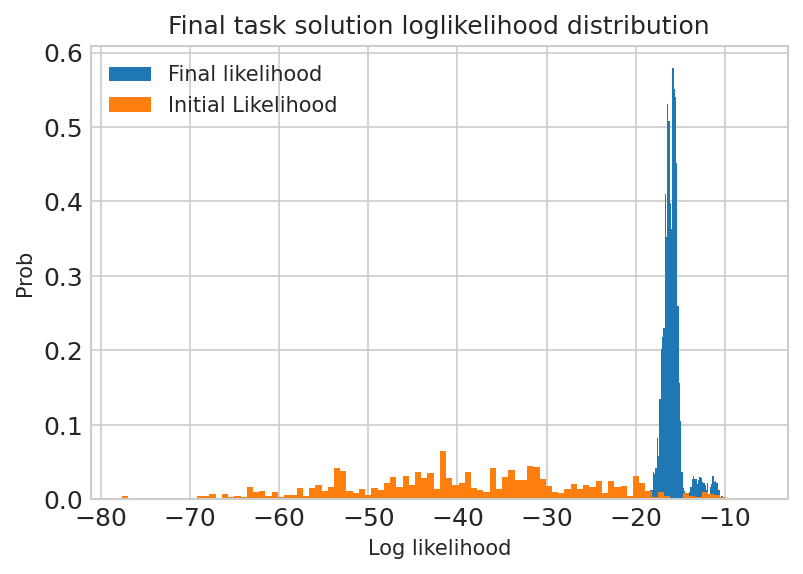

In [ ]:
plt.figure(dpi=150)
plt.title("Final task solution loglikelihood distribution")
plt.hist(train_loglikelihoods,100, density=True, label="Final likelihood");
plt.hist(initial_loglikelihoods,100, density=True, label="Initial Likelihood");
# plt.hist(full_loglikelihoods,100, density=True, label="Full set Likelihood");
plt.xlabel("Log likelihood")
plt.ylabel("Prob")
plt.legend()
plt.show()

Plot primitive usage evolution

In [ ]:
# WARNING! IT IS NOT REALLY A PROBABILITY, 
# Some factor is missing!
def get_tasks_dict(results):
    tasks_dict = {}
    for task, frontiers in results.frontiersOverTime.items():
        for idx_f, f in enumerate(frontiers):
            if len(f.entries)>0:
                grammar = results.grammars[idx_f]
                if task.name not in tasks_dict: tasks_dict[task.name]=[]
                # TODO: needs to sort f.entries according to logPrior
                entries=sorted(f.entries, key=lambda x:x.logPrior)
                program = entries[-1].program
                tasks_dict[task.name].append([idx_f, #iteration
                                              grammar.logLikelihood(program.infer(),program), #likelihood
                                            #   f.entries[-1]] # program frontier
                ])
    return tasks_dict
tasks_dict = get_tasks_dict(results)
len(tasks_dict)

500

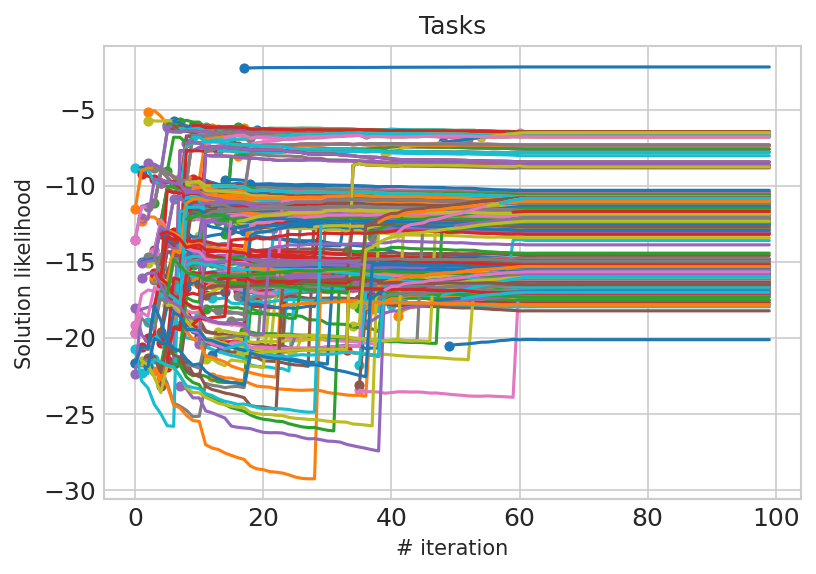

In [ ]:
plt.figure(dpi=150)
for idx, (task, vals) in enumerate(tasks_dict.items()):
    vals_array =np.array(vals)
    plt.plot(*vals_array.T)
    plt.scatter(*vals_array[0], s=15)
    # plt.annotate(idx, vals_array[0])
plt.title("Tasks")
plt.xlabel("# iteration")
plt.ylabel("Solution likelihood")
# plt.semilogy()
plt.show()

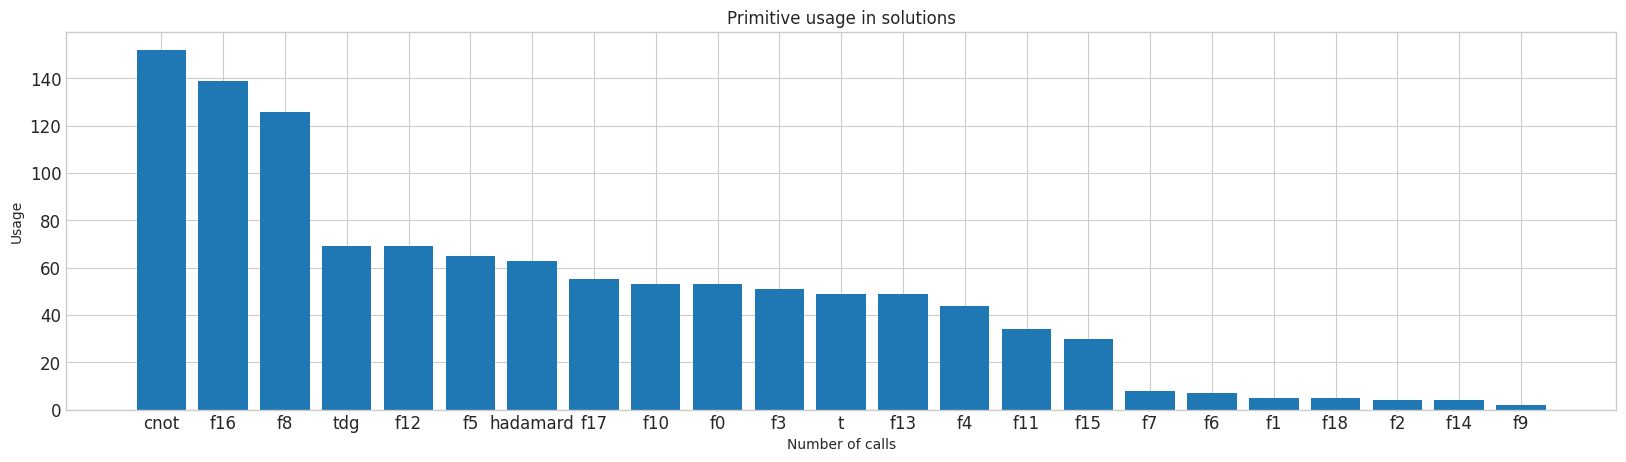

In [ ]:
# That's in the train set -> TODO: analyze it in the test set
primitive_counts_list = list(primitive_counts.items())
primitive_counts_list.sort(key=lambda x: -x[1])
plt.figure(dpi=100, figsize=[20,5])
plt.title("Primitive usage in solutions")
plt.xlabel("Number of calls")
plt.ylabel("Usage")
plt.bar(np.array(primitive_counts_list)[:,0], np.array(primitive_counts_list)[:,1].astype(int))
plt.show()

---

Testing enumeration

In [16]:
name_reverse = {v:k for k,v in name.items()}
def replace_back_full_primitives(program):
    program = str(program)
    while True:
        for n in name_reverse:
            program = program.replace(f"{n} ",str(name_reverse[n])+ " ")
        if "f" not in name_reverse:
            break
    return program

In [17]:
for idx,(task, frontier) in enumerate(r.frontiersOverTime.items()):
    if "t_267_" in task.name:
        break

In [22]:
for idx,(task, frontier) in enumerate(r.frontiersOverTime.items()):
    if "t_32941_" in task.name:
        break
    
true_circuit = get_qiskit_circuit((n_qubit_tasks, task.target_circuit))
print(f"---------------------------------------")
print(f"Task {task.name}")
print("True")
print(true_circuit.circuit)

# code = dc.program.Program.parse("(lambda (lambda (lambda (lambda (f18 (f11 (f6 $0 $3 $2) $3 $1) $1)))))")
code = dc.program.Program.parse(replace_back_full_primitives("(lambda (lambda (lambda (lambda (f18 (f11 $3 (f6 $3 $0 $2) $1) $1)))))"))
arguments = (*range(n_qubit_tasks),(n_qubit_tasks,()))
circuit = execute_program(code,arguments)
reconstructed_circuit = get_qiskit_circuit(circuit)
print("Reconstructed")
print(reconstructed_circuit.circuit)

task.logLikelihood(code)

replaced_code = dc.program.Program.parse(replace_back_full_primitives(code))

---------------------------------------
Task t_32941_(lambda (lambda (lambda (lambda (y (ch (cs $0 $2 $3) $1 $3) $1)))))
True
               ┌───┐
q_0: ───────■──┤ Y ├
            │  └───┘
q_1: ──■────┼───────
     ┌─┴─┐┌─┴─┐     
q_2: ┤ S ├┤ H ├─────
     └───┘└───┘     
Reconstructed
                              ┌───┐     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
q_0: ────────────■────────────┤ X ├──■──┤ T ├┤ T ├┤ T ├┤ T ├┤ H ├┤ T ├┤ T ├»
     ┌───┐┌───┐  │  ┌───┐     └─┬─┘  │  └───┘└───┘└───┘└───┘└───┘└───┘└───┘»
q_1: ┤ X ├┤ T ├──┼──┤ T ├───────┼────┼─────────────────────────────────────»
     └─┬─┘└───┘┌─┴─┐├───┤┌───┐  │  ┌─┴─┐                                   »
q_2: ──■───────┤ X ├┤ T ├┤ T ├──■──┤ X ├───────────────────────────────────»
               └───┘└───┘└───┘     └───┘                                   »
«     ┌───┐┌───┐┌───┐
«q_0: ┤ T ├┤ T ├┤ H ├
«     └───┘└───┘└───┘
«q_1: ───────────────
«                    
«q_2: ───────────────
«                    


[-17.900579936067537,
 -17.912383463997585,
 -17.93512616605183,
 -17.95053676786994,
 -17.96095614552934,
 -17.974911936916293,
 -17.99793773223593,
 -18.017401064560996,
 -18.046179816408817,
 -18.076672197193986,
 -18.12096307957254,
 -18.133159340452906,
 -18.133159340452906,
 -18.126690299709793,
 -18.126540786090604,
 -18.126540786090604,
 -18.126540786090604,
 -18.12656791858831,
 -18.126585391226296,
 -18.126435908168837,
 -18.126435908168837,
 -18.12645338054844,
 -18.12645338054844,
 -18.12645338054844,
 -18.12645338054844,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605,
 -18.126470852825605

In [92]:
code = dc.program.Program.parse("(lambda (lambda (lambda (lambda (f11 $0 $3 $1)))))")
arguments = (*range(n_qubit_tasks),(n_qubit_tasks,()))
circuit = execute_program(code,arguments)
reconstructed_circuit = get_qiskit_circuit(circuit)
print("Reconstructed")
print(reconstructed_circuit.circuit)

task.logLikelihood(code)

replaced_code = dc.program.Program.parse(replace_back_full_primitives(code))
g.logLikelihood(replaced_code.infer(),replaced_code)

Reconstructed
     ┌──────┐
q_0: ┤1     ├
     │      │
q_1: ┤  f11 ├
     │      │
q_2: ┤0     ├
     └──────┘


-6.516377444220209

Testing enumerated programs

In [ ]:
enumerated_programs = []
with open("logs/tjob_three-long-log-4_3462582_4294967294_err.txt","r") as f:
    for line in f:
        if "[94mgrammar.py:1991[0m >" in line:
            enumerated_programs.append(line[27:].replace("\n",""))

In [ ]:
simplified_enumerated_programs = []
for p in tqdm(enumerated_programs):
    s = get_program_simplification(dc.program.Program.parse(p))
    if "f18" in str(s) and "f11" in str(s) and "f6" in str(s):
        print("Candidate:", str(s))
        simplified_enumerated_programs.append(s)

  0%|          | 8474/2927897 [00:05<40:03, 1214.68it/s]

In [ ]:
arguments = (*range(n_qubit_tasks),(n_qubit_tasks,()))
circuit = execute_program(a,arguments)

Fidelity check

In [ ]:
program = dc.program.Program.parse("(lambda (lambda (lambda (lambda (swap $0 $2 $3)))))")
circuit = execute_program(program, arguments)
circuit_to_mat(circuit).round(3)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
np.pi*1j

3.141592653589793j

In [ ]:
mat = circuit_to_mat(circuit)
mat2 = mat*np.exp(np.pi/4*1j)

In [ ]:
np.trace(np.matmul(mat.conj().T, mat))/len(mat)

0.5

In [ ]:
# mat2 = task.target_circuit_evaluation
np.trace(np.matmul(mat2.conj().T, mat))/len(mat)

(0.7071067811865476-0.7071067811865475j)

In [ ]:
task.logLikelihood(dc.program.Program.parse("(lambda (lambda (lambda (lambda (swap $0 $2 $3)))))"))

-inf